In [1]:
import jax
import jax.numpy as jnp
from jax import vmap
import numpyro
import numpyro.distributions as dist
from numpyro import sample
import multiprocessing
import os

# Set number of CPU cores JAX will use
num_cores = multiprocessing.cpu_count()  # Get number of available CPU cores
# Use num_cores-1 to leave one core for system tasks
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={num_cores-1}"
print(f"Using {num_cores-1} cores for JAX")

# Configure thread count for better performance
os.environ["OPENBLAS_NUM_THREADS"] = str(num_cores-1)
os.environ["MKL_NUM_THREADS"] = str(num_cores-1)

# Basic configuration
jax.config.update("jax_enable_x64", False)
jax.config.update("jax_platform_name", "cpu")
numpyro.set_platform("cpu")

# For NumPyro, increase the number of threads
numpyro.set_host_device_count(num_cores-1)

Using 11 cores for JAX


# Define Functions and constants

In [2]:
c = 299792.458  # speed of light in km/s


def H(z, H0, Om, Ok):
    """Hubble parameter at redshift z"""
    OL = 1 - Om - Ok  # Non-flat universe: Omega_Lambda = 1 - Omega_m - Omega_k
    return H0 * jnp.sqrt(jnp.maximum(Om * (1 + z)**3 + Ok * (1 + z)**2 + OL, 1e-10))

def luminosity_distance(z, Om, Ok, H0):
    """Calculate luminosity distance in Mpc for non-flat universe"""
    # Simple rectangle rule integration for comoving distance
    N = 1000  # number of points
    z_array = jnp.linspace(0, z, N)
    dz = z_array[1] - z_array[0]
    
    integrand_values = vmap(lambda z_: c / H(z_, H0, Om, Ok))(z_array)
    chi = jnp.sum(integrand_values) * dz
    
    # For non-flat universe, need to account for curvature
    sqrt_abs_Ok = jnp.sqrt(jnp.abs(Ok)) * H0 / c
    
    # Define the three possible cases using lax.select
    flat_case = chi
    open_case = (c / (H0 * sqrt_abs_Ok)) * jnp.sinh(sqrt_abs_Ok * chi)
    closed_case = (c / (H0 * sqrt_abs_Ok)) * jnp.sin(sqrt_abs_Ok * chi)
    
    # Select appropriate case based on Ok
    dM = jnp.where(jnp.abs(Ok) < 1e-10,
                   flat_case,
                   jnp.where(Ok > 0,
                            open_case,
                            closed_case))
    
    return jnp.maximum((1 + z) * dM, 1e-10)  # Ensure positive distance

def distance_modulus(z, Om, Ok, H0):
    """Calculate distance modulus"""
    dL = luminosity_distance(z, Om, Ok, H0)
    return 5 * jnp.log10(jnp.maximum(dL, 1e-10)) + 25

# Vectorize the distance modulus calculation
distance_modulus_vec = vmap(distance_modulus, in_axes=(0, None, None, None))

def model(z, mu_obs, mu_err):
    # Priors
    H0 = sample("H0", dist.Uniform(60, 80))     # Uniform prior on H0
    Om = sample("Om", dist.Uniform(0.1, 0.9))   # Uniform prior on Omega_m
    Ok = sample("Ok", dist.Uniform(-0.1, 0.1))  # Uniform prior on Omega_k
    
    # Calculate expected distance modulus
    mu_exp = distance_modulus_vec(z, Om, Ok, H0)
    
    # Likelihood (assuming independent measurements)
    sample("obs", dist.Normal(mu_exp, mu_err), obs=mu_obs)

In [3]:
# load data
import pandas as pd
df = pd.read_csv('Pantheon+SH0ES.dat', sep='\s+', header=0)

In [4]:
from numpyro.infer import MCMC, NUTS

# Prepare data
z = df['zHD'].values
mu = df['MU_SH0ES'].values
mu_err = df['MU_SH0ES_ERR_DIAG'].values

# Setup inference
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=len(z))

# Run inference
mcmc.run(jax.random.PRNGKey(0), z, mu, mu_err)

# Print results
mcmc.print_summary()

sample: 100%|██████████| 2201/2201 [22:43<00:00,  1.61it/s, 31 steps of size 2.45e-02. acc. prob=0.78]   



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        H0     80.00      0.00     80.00     80.00     80.00     13.13      1.07
        Ok      0.10      0.00      0.10      0.10      0.10    958.10      1.00
        Om      0.90      0.00      0.90      0.90      0.90    862.42      1.00

Number of divergences: 0


# Make Figures of result

/Users/yhra/miniconda3/envs/BATIP/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


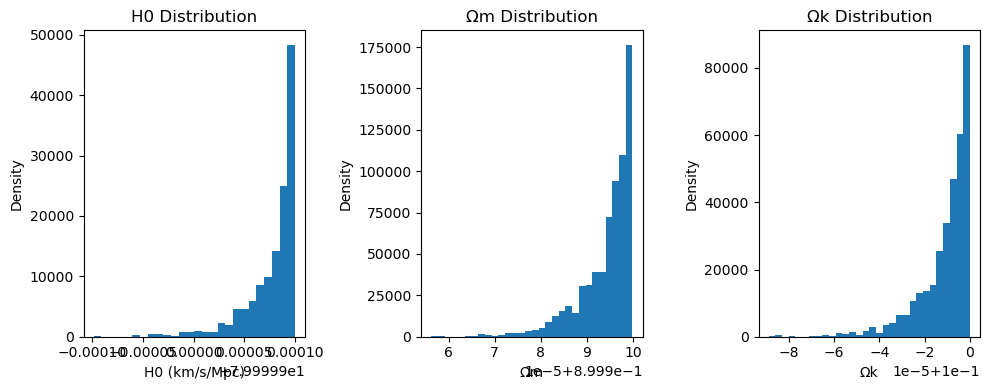

Infered Parameters:
H0: 80.00 ± 0.00
Ωm: 0.90 ± 0.00
Ωk: 0.10 ± 0.00
OL: 0.10 ± 0.00


In [5]:
import matplotlib.pyplot as plt
# Get samples
samples = mcmc.get_samples()

# Create figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

# Plot H0 histogram
ax1.hist(samples['H0'], bins=30, density=True)
ax1.set_xlabel('H0 (km/s/Mpc)')
ax1.set_ylabel('Density')
ax1.set_title('H0 Distribution')

# Plot Om histogram 
ax2.hist(samples['Om'], bins=30, density=True)
ax2.set_xlabel('Ωm')
ax2.set_ylabel('Density')
ax2.set_title('Ωm Distribution')

# Plot Ok histogram
ax3.hist(samples['Ok'], bins=30, density=True)
ax3.set_xlabel('Ωk')
ax3.set_ylabel('Density')
ax3.set_title('Ωk Distribution')

plt.tight_layout()
plt.show()

print("Infered Parameters:")
print("H0: {:.2f} ± {:.2f}".format(jnp.mean(samples['H0']), jnp.std(samples['H0'])))
print("Ωm: {:.2f} ± {:.2f}".format(jnp.mean(samples['Om']), jnp.std(samples['Om'])))
print("Ωk: {:.2f} ± {:.2f}".format(jnp.mean(samples['Ok']), jnp.std(samples['Ok'])))
print("OL: {:.2f} ± {:.2f}".format(1-jnp.mean(samples['Om']), jnp.std(samples['Om'])))